# MNIST Basics

In [1]:
from fastai.vision.all import *
matplotlib.rc('image', cmap='Greys')

Download a sample of MNIST with only the digits 3 and 7. We will try and create a binary classifier.

In [2]:
path = untar_data(URLs.MNIST_SAMPLE)

Show path relative to `BASE_PATH`

In [6]:
Path.BASE_PATH = path

In [10]:
path

Path('.')

In [7]:
path.ls()

(#3) [Path('valid'),Path('labels.csv'),Path('train')]

In [9]:
(path/'train').ls()

(#2) [Path('train/3'),Path('train/7')]

In [12]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

In [13]:
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [17]:
im3 = Image.open(threes[1])
im3

In [18]:
type(im3)

PIL.PngImagePlugin.PngImageFile

Cast the image as a NumPy array

In [19]:
array(im3)[4:10, 4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

Cast the image as a PyTorch tensor

In [20]:
tensor(im3)[4:10, 4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [21]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


## Build a baseline model

In life generally, when building models, how do you know whether what you've built is any good? You need something to compare to. You can compare to the state of the art, but that 

1. Assumes you're trying to solve a problem someone has already tried to solve
1. Only gives a sense of what a great model looks like, rather than an "ok" model

Let's build a baseline model which builds an "ideal" 3 and an "ideal" 7 just using the arithmetic mean of all the training examples, and use pixel similarity to build a classifier.

In [23]:
seven_tensors = [tensor(Image.open(x)) for x in sevens]
three_tensors = [tensor(Image.open(x)) for x in threes]

In [25]:
len(seven_tensors), len(three_tensors)

(6265, 6131)

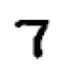

In [28]:
show_image(seven_tensors[0]);

In [29]:
seven_tensors[0].shape

torch.Size([28, 28])

Compute the pixel-wise average, by stacking the list of images to generate a rank-3 data tensor 

In [30]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255

In [31]:
stacked_sevens.shape

torch.Size([6265, 28, 28])

In [32]:
mean3 = stacked_threes.mean(0)
mean7 = stacked_sevens.mean(0)

Here are our archetypal digits

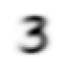

In [34]:
show_image(mean3);

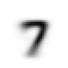

In [35]:
show_image(mean7);

Compute the mean absolute difference, and the root mean squared error between an image of a 3 and our archtypes

In [47]:
a_3 = stacked_threes[1]

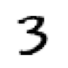

In [48]:
show_image(a_3);

In [49]:
dist_3_mad = (a_3 - mean3).abs().mean()
dist_3_rmse = ((a_3 - mean3)**2).mean().sqrt()
dist_3_mad, dist_3_rmse

(tensor(0.1114), tensor(0.2021))

In [50]:
dist_7_mad = (a_3 - mean7).abs().mean()
dist_7_rmse = ((a_3 - mean7)**2).mean().sqrt()
dist_7_mad, dist_7_rmse

(tensor(0.1586), tensor(0.3021))

We can also use the PyTorch loss functions in `torch.nn.functional`, which is imported as `F`

In [54]:
F.l1_loss(a_3, mean3), F.mse_loss(a_3, mean3).sqrt()

(tensor(0.1114), tensor(0.2021))